# Predicting movie ratings and recommendation system

![](http://)## Overview of this project

I used machine learning to predict a movie's score and cosine similarity for recommendation system.For this project, I will be using the [5000 movies dataset][db], and supervised learning, to predict the user score for a film.



For my project, instead of using a cosine-similarity algorithm, I will use machine learning to predict a movie's score. To do this, I will: 
- create a decimal representation of the features: genres, actors, directors, keywords, and production companies
  - Like Swain has done, I will create a binary array for each feature. Then, I will analyze the array like points in a number line
    - Looking at the points, I can identify a point that best describes the distribution of 1's, and use that as a decimal representation of the feature
- normalize the decimal values to be within [0,1]
- Split data into training and testing sets
  - 70% for training, 30% for testing
- Train a regression-based model using Scikit learn's Bayesian Ridge
- Make predictions and evaluate using an R^2 score



## Setup
### Import Modules

In [119]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import json #converting JSON to lists for dataframe
import warnings
warnings.filterwarnings('ignore')
import base64
import codecs
from IPython.display import HTML

%matplotlib inline

In [120]:
movie = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_movies.csv")
credit = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_credits.csv")
credit.columns = ['id','tittle','cast','crew']
movies = movie.merge(credit,on='id')

In [121]:
movies = movies[(movies['vote_average']!=0)]

Quick look at movies

In [122]:
movie.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


###  Format dataframe
Features: **genres, keywords, cast, crew, and production companies** are all in JSON format. Convert to simple list via following function

In [123]:

def to_list(df, feature_names_list): #df: dataframe, feature_names: list of all features to convert from JSON to list
    for feature_name in feature_names_list:
        print("Current:", feature_name)
        #STEP 1: convert JSON format to a list
        df[feature_name]=df[feature_name].apply(json.loads)
        #Two cases here: Feature is crew, or feature is not crew
        if feature_name == 'crew': #if crew, due to large size, want to limit to most influential members: director, editor, cinematographer, screenplay, and composer
            for index,i in zip(df.index,df[feature_name]):
                feature_list_1=[]
                limit = 10
                if len(i) < 10:
                    limit = len(i)
                for j in range(limit): #top 10 crew members
                    feature_list_1.append((i[j]['name'])) # the key 'name' contains the name of the a sub-feature (ex: sci-fi in genres)
                df.loc[index,feature_name]= str(feature_list_1)
        
        elif feature_name == 'cast': #Another special case. Only want top 5 cast members (most infulential)
            for index,i in zip(df.index,df[feature_name]):
                feature_list_1=[]
                if len(i) > 5:
                    limit = 5
                else:
                    limit = len(i)
                for j in range(limit): #top 5 (JSON format already has this sorted)
                    feature_list_1.append((i[j]['name']))
                df.loc[index,feature_name]= str(feature_list_1)
        else:    
            for index,i in zip(df.index,df[feature_name]):
                feature_list_1=[]
                for j in range(len(i)):
                    feature_list_1.append((i[j]['name']))
                df.loc[index,feature_name]= str(feature_list_1)
    
        #STEP 2: clean up and transform into unsorted list
        df[feature_name] = df[feature_name].str.strip('[]').str.replace(' ','').str.replace("'",'')
        df[feature_name] = df[feature_name].str.split(',')
        
        #STEP 3: Sort list elements
        for i,j in zip(df[feature_name],df.index):
            features_list_2=i
            features_list_2.sort()
            df.loc[j,feature_name]=str(features_list_2)
        df[feature_name]=df[feature_name].str.strip('[]').str.replace(' ','').str.replace("'",'')
        lst = df[feature_name].str.split(',')
        if len(lst) == 0:
            df[feature_name] = None
        else:
            df[feature_name]= df[feature_name].str.split(',')
    return df

In [124]:
movies = to_list(movies, ['genres', 'keywords', 'production_companies', 'cast', 'crew']) #function call

Current: genres
Current: keywords
Current: production_companies
Current: cast
Current: crew


Every dataset contain some feature with empty olumns lets remove them

In [125]:
to_drop = []
for i in movies.index:
    if (movies['production_companies'][i] == [''] and movies['cast'][i] == [''] and 
        movies['crew'][i] == ['']):
        to_drop.append(i)
print('Dropping', str(len(to_drop)), 'movies.')
movies = movies.drop(to_drop, axis = 0)

Dropping 8 movies.


In [126]:
movies.shape[0]

4732

#### Remove un-needed feature-types in dataframe

In [127]:
movies_shortened = movies[['id','original_title','genres','cast', 'crew', 'production_companies', 'keywords', 'vote_average']]

Lets make an histogram for distribution of movie ratings

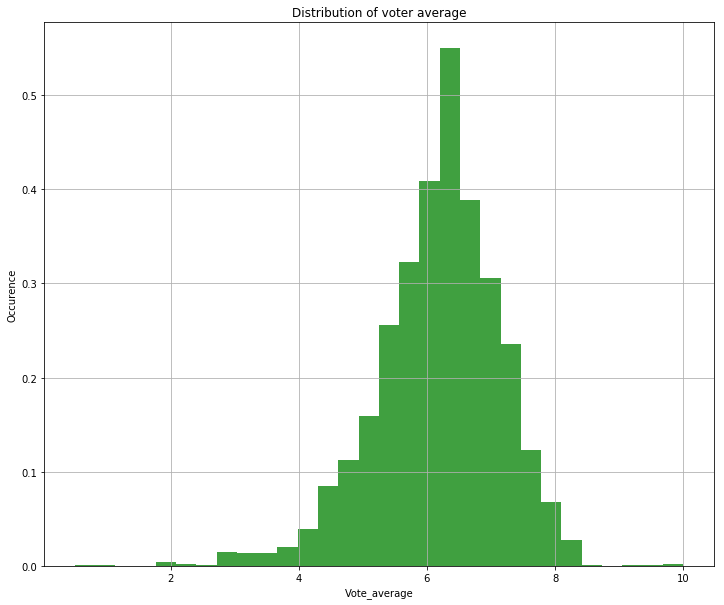

Minimum of Ratings: 0.5
Maximum of Ratings: 10.0
Average of Ratings: 6.17
Variance of Ratings: 0.93


In [128]:
plt.subplots(figsize=(12,10))
n, bins, patches = plt.hist(movies_shortened['vote_average'], 30, density=1, facecolor='g', alpha=0.75)

plt.xlabel('Vote_average')
plt.ylabel('Occurence')
plt.title('Distribution of voter average')
plt.grid(True)
plt.show()
print("Minimum of Ratings:", round(min(movies_shortened['vote_average']),2))
print("Maximum of Ratings:", round(max(movies_shortened['vote_average']),2))
print("Average of Ratings:", round(np.mean(movies_shortened['vote_average']),2))
print("Variance of Ratings:",round(np.var(movies_shortened['vote_average']),2))

## Feature Engineering: Turn lists of features into numerical representations

### Step 1: Identify all unique sub-feature for each feature (ex: all unique cast members in the cast category)
#### Organize sub-features to lowest-rating association to highest-rating association
By organizing features in this order, the numerical representation will then also describe the quality of features associated with the movie
- higher quality feature values should correlate with higher-rated movies, and vice versa

In [129]:
def generate_list(df, feature_name): #create a list of all unique feature values
    #Step 1: track all ratings associated with each feature in a dictionary
    feature_dict = {}
    for index, row in df.iterrows():
        feat = row[feature_name]
        for sub_feat in feat:
            if sub_feat not in feature_dict:
                feature_dict[sub_feat] = (df['vote_average'][index], 1) #
            else:
                feature_dict[sub_feat] = (feature_dict[sub_feat][0] + (df['vote_average'][index]), feature_dict[sub_feat][1] + 1)
    #Step 2: calculate average ratings for each feature
    for key in feature_dict:
        feature_dict[key] = feature_dict[key][0]/feature_dict[key][1] #average of all vote_averages
       
    #Step 3: create and sort a list of tuples (dictionary value, key)
    lst = list()
    for name in feature_dict:
        lst.append((feature_dict[name],name))
    lst = sorted(lst)
    #step 4: create a list of only the feature names, from lowest rating to highest rating
    feature_list = list()
    ratings_list = list()
    for element in lst:
        feature_list.append(element[1])
        ratings_list.append(element[0])
    
    #get the variance of the ratings. This is helpful for determining the usefulness of the information (to be displayed in below plot)
    var = round(np.var(ratings_list),3)
    
    #before returning the list, do a quick visualization to show that generate_list works
    fig, ax = plt.subplots(figsize=(6,5))
    if feature_name != 'genres':
        n = 50 # sample at intervals of n
    else:
        n = 1
    X = [] #sample for associated movie(s) rating average
    Y = [] #sample for feature names
    for i in range(0, len(feature_list) - 1, n):
        X.append(ratings_list[i])
        Y.append(feature_list[i])
    
    y_pos = np.arange(len(Y))
    ax.barh(y_pos, X, align='center')
    #ax.set_yticklabels(Y)
    ax.invert_yaxis()  # labels read top-to-bottom
    
    ax.set_xlabel('Overall average movie ratings')
    ax.set_ylabel(feature_name + ' sample list index')
    ax.set_title(feature_name + ' to associated movie(s) performance (' + str(int(len(feature_list)/n)) + ' samples), variance: ' + str(var))
    
    plt.show()
    
    return feature_list


### Create lists for each feature

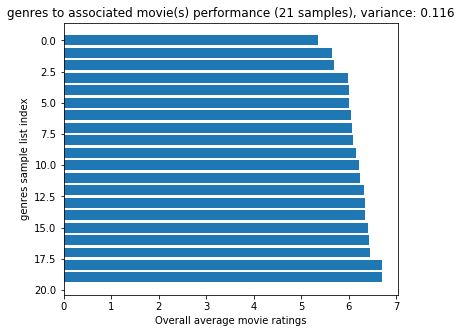

In [130]:
genres_list = generate_list(movies_shortened, 'genres')

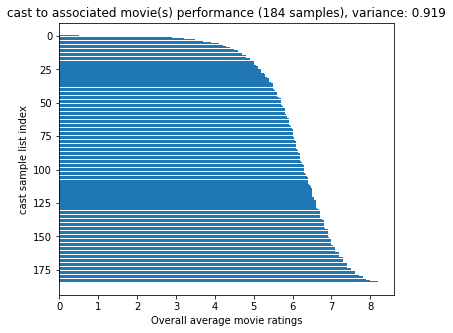

In [131]:
cast_list = generate_list(movies_shortened, 'cast')

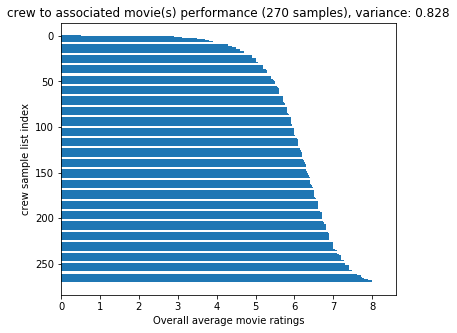

In [132]:
crew_list = generate_list(movies_shortened, 'crew')

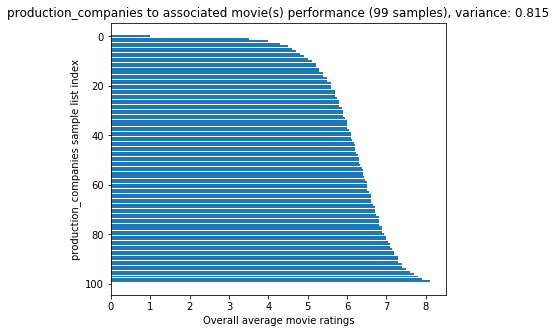

In [133]:
prod_companies_list = generate_list(movies_shortened, 'production_companies')

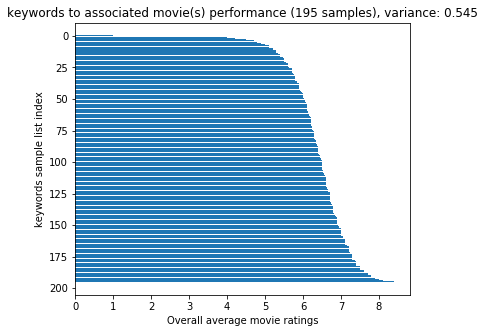

In [134]:
keywords_list = generate_list(movies_shortened, 'keywords')

### Analysis

Most of the features show some variance except genra so lets drop genre from movies_shortened


In [135]:
movies_shortened = movies_shortened[['id', 'original_title', 'cast', 'crew', 'production_companies', 'keywords','vote_average']]

### Step 2: Create a binary representation for each feature

##### Using the lists created, create binary arrays that indicated whether or not feature_name can be found in this movie

note: each array represents a feature associated with movies with lowest average ratings to highest average ratings
- this is useful because we can use the array as a gauge for how well the features track record in movies are

In [136]:
def calculate_bin_array(this_list, all_features):
    bin_list = []
    for element in all_features:
        if element in this_list:
            bin_list.append(1)
        else:
            bin_list.append(0)
    return bin_list

In [137]:
movies_shortened['cast'] = movies_shortened['cast'].apply(lambda x: calculate_bin_array(x, cast_list))

In [138]:
movies_shortened['crew'] = movies_shortened['crew'].apply(lambda x: calculate_bin_array(x, crew_list))

In [139]:
movies_shortened['production_companies'] = movies_shortened['production_companies'].apply(lambda x: calculate_bin_array(x, prod_companies_list))

In [140]:
movies_shortened['keywords'] = movies_shortened['keywords'].apply(lambda x: calculate_bin_array(x, keywords_list))

In [141]:
movies_shortened.sample(5)

,id,original_title,cast,crew,production_companies,keywords,vote_average
4260,44413,La niña santa,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.8
4701,5822,Sweet Sweetback's Baadasssss Song,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.6
4257,301325,#Horror,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.3
1141,65,8 Mile,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.8
2846,14191,Aquamarine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.8


### Look at distribution of 1's in a number-line format

In [142]:
def plot_bin(mov):
    cast_bin = mov[2]
    cast_index = []
    # create arrays of indeces where bin number is one
    for i in range(len(cast_bin)):
        if cast_bin[i] == 1:
            cast_index.append(i)
    
    crew_bin = mov[3]
    crew_index = []
    for i in range(len(crew_bin)):
        if crew_bin[i] == 1:
            crew_index.append(i)
    
    prod_bin = mov[4]
    prod_index = []
    for i in range(len(prod_bin)):
        if prod_bin[i] == 1:
            prod_index.append(i)
    
    keywords_bin = mov[5]
    keywords_index = []
    for i in range(len(keywords_bin)):
        if keywords_bin[i] == 1:
            keywords_index.append(i)
    
    font = {'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 10,
        }
    
    fig, ax = plt.subplots(4,1,figsize=(5,1))
    plt.subplots_adjust(hspace = 5)
    ax[0].scatter(cast_index, np.zeros_like(cast_index), vmin=-2)
    ax[0].set_title('Cast', loc = 'left', fontdict=font)
    ax[0].set_xlim(0,len(cast_bin))
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    
    ax[1].scatter(crew_index, np.zeros_like(crew_index), vmin=-2)
    ax[1].set_title('Crew', loc = 'left', fontdict=font)
    ax[1].set_xlim(0,len(crew_bin))
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    
    ax[2].scatter(prod_index, np.zeros_like(prod_index), vmin=-2)
    ax[2].set_title('Production companies', loc = 'left', fontdict=font)
    ax[2].set_xlim(0,len(prod_bin))
    ax[2].set_yticks([])
    ax[2].set_xticks([])
    
    ax[3].scatter(keywords_index, np.zeros_like(keywords_index), vmin=-2)
    ax[3].set_title('Keywords', loc = 'left', fontdict=font)
    ax[3].set_xlim(0,len(keywords_bin))
    ax[3].set_yticks([])
    ax[3].set_xticks([])


In [143]:
movies_sample = movies_shortened.sample(5)

Movie: Peggy Sue Got Married
Rating: 5.9



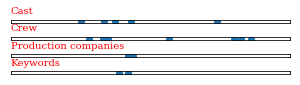

In [144]:
print('Movie: ' + movies_sample.iloc[0][1] + '\nRating: ' + str(movies_sample.iloc[0][-1]) + '\n')
plot_bin(movies_sample.iloc[0])

Movie:The Taking of Pelham 1 2 3
Rating: 6.2



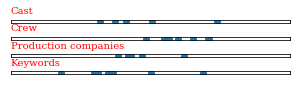

In [145]:
print('Movie:' + movies_sample.iloc[1][1] + '\nRating: ' + str(movies_sample.iloc[1][-1]) + '\n')
plot_bin(movies_sample.iloc[1])

Movie:Young Frankenstein
Rating: 7.7



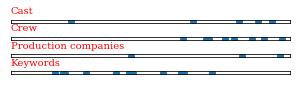

In [146]:
print('Movie:' + movies_sample.iloc[2][1] + '\nRating: ' + str(movies_sample.iloc[2][-1]) + '\n')
plot_bin(movies_sample.iloc[2])

Movie:Imagine Me & You
Rating: 7.0



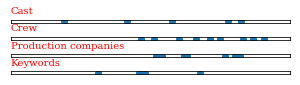

In [147]:
print('Movie:' + movies_sample.iloc[3][1] + '\nRating: ' + str(movies_sample.iloc[3][-1]) + '\n')
plot_bin(movies_sample.iloc[3])

Movie:Unbreakable
Rating: 6.9



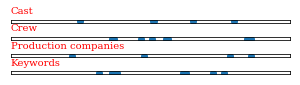

In [148]:
print('Movie:' + movies_sample.iloc[4][1] + '\nRating: ' + str(movies_sample.iloc[4][-1]) + '\n')
plot_bin(movies_sample.iloc[4])

#### Analysis
 - Movies with lower ratings have features leaning towards the left, while movies with higher ratings have features leaning to the right. 
 - This shows that there's a relationship between features and ratings if feature names is organized from lowest movie rating associations to highest movie rating associations

### Step 3: Find concentration points in each array
Find areas where numbers are grouped, and identify points that resemble the centers of binary distribution

    Generic example: [1110001111100101] -> [0300000050000020] -> [(1,3), (8,5), (14,2)] tuple[0] is the index of concentration, tuple[1] is the number of 1's about index

In [149]:
def split_arr(arr, n_splits): 
      
    # looping till length l 
    for i in range(0, len(arr), n_splits):  
        yield arr[i:i + n_splits] 

def find_concentration(arr, n = 100): # n is the number of concentration points to find
    #seperate array into batches
    batches = list(split_arr(arr,int(len(arr)/n)))
    concentrations = []
    for i in range(len(batches)):
        point = 0
        num_ones = 0
        for j in range(len(batches[i])):
            if batches[i][j] == 1:
                point += j + (i * int(len(arr)/n)) # adding correction for batches
                num_ones += 1
        if num_ones > 0:
            point = point/num_ones
            concentrations.append((point,num_ones))
    return concentrations

In [150]:
def to_concentrations(df, feature_names):
    for feature_name in feature_names:
        print('feature: ', feature_name)
        df[feature_name] = df[feature_name].apply(lambda x: find_concentration(x))
    return df

In [151]:
movies_shortened = to_concentrations(movies_shortened, ['cast', 'crew', 'production_companies', 'keywords'])

feature:  cast
feature:  crew
feature:  production_companies
feature:  keywords


In [152]:
movies_shortened.sample(10)

,id,original_title,cast,crew,production_companies,keywords,vote_average
851,9566,The Fan,"[(3065.0, 1), (3414.0, 1), (5146.0, 1), (5576....","[(3331.0, 1), (6281.0, 1), (8155.0, 1), (8336....","[(1644.0, 1), (2097.0, 1)]","[(1334.6666666666667, 3), (1444.0, 1), (1465.0...",5.7
4711,178862,Aroused,"[(8155.666666666667, 3), (8215.5, 2)]","[(12087.25, 4), (12202.5, 4)]","[(4337.0, 1)]","[(2164.0, 1), (2987.0, 1), (3019.0, 1), (4672....",7.2
3296,149,アキラ,"[(9045.4, 5)]","[(12268.0, 1), (13295.0, 7)]","[(3828.0, 1), (4021.0, 1), (4156.0, 1), (4841....","[(1849.0, 1), (3065.0, 1), (3638.0, 1), (4155....",7.8
3641,14474,The Oh in Ohio,"[(727.0, 1), (2845.0, 1), (2979.0, 1), (3403.0...","[(3834.5, 2), (4150.0, 1)]","[(1265.0, 1), (2094.0, 1), (2158.0, 1), (2444....","[(385.0, 1), (820.0, 1), (2489.0, 1), (2679.0,...",5.8
394,59108,Tower Heist,"[(2743.0, 1), (3898.5, 2), (4363.5, 2)]","[(1851.0, 1), (3762.0, 1), (5040.0, 1), (6110....","[(1078.0, 1), (1441.0, 1), (2090.0, 1), (2394....","[(1108.0, 1), (1303.0, 1), (1607.0, 2), (1705....",5.8
3462,14144,Daddy Day Camp,"[(500.6666666666667, 3), (935.0, 1), (3446.0, 1)]","[(582.0, 2), (2127.0, 1), (2382.0, 1)]","[(941.0, 1), (2097.0, 1)]","[(840.0, 1), (1258.0, 1), (2499.0, 1), (3015.0...",4.4
2671,2604,Born on the Fourth of July,"[(4813.5, 2), (6432.0, 1), (6583.0, 1), (6642....","[(4374.0, 1), (5613.0, 1), (7716.0, 1), (8285....","[(2394.0, 1), (3160.0, 1)]","[(3220.0, 2), (4804.0, 1), (5330.0, 1), (5549....",6.7
3913,22013,Elmer Gantry,"[(6108.0, 1), (8058.0, 1), (8298.0, 1), (8427....","[(9707.0, 1), (12345.5, 4), (12513.0, 1), (128...","[(3421.0, 1)]","[(8702.0, 1), (8796.0, 1)]",7.3
958,2116,Out of Time,"[(2605.0, 1), (3025.0, 1), (5569.0, 1), (6128....","[(3247.0, 1), (3667.0, 1), (4814.0, 1), (4930....","[(1434.0, 1), (1922.0, 1), (2024.0, 1)]","[(2997.0, 1), (3092.0, 1), (4345.0, 1), (5563....",6.1
1742,254473,Brick Mansions,"[(1231.0, 1), (2380.0, 1), (2527.0, 1), (4010....","[(2848.0, 1), (3353.0, 1), (3429.6666666666665...","[(1136.0, 1), (2149.0, 1), (2405.0, 1), (2916....","[(848.0, 1), (1535.0, 1), (2564.0, 1), (2859.0...",5.7


### Step 3.1: Find a decimal value that represents the concentration points
The point will represent the weighted average of all points of concentration
The weight is the number of ones for each concentration point

In [153]:
def w_avg(arr):
    weight = 0 #weight
    s = 0 # position*weight
    for element in arr:
        s += (element[0] * element[1])
        weight += element[1]
    return s/weight #weighted average

In [154]:
def to_weighted_avg(df, feature_names):
    for feature_name in feature_names:
        print('Current: ', feature_name)
        df[feature_name] = df[feature_name].apply(lambda x: w_avg(x))
    return df

In [155]:
movies_shortened = to_weighted_avg(movies_shortened, ['cast', 'crew', 'production_companies', 'keywords'])

Current:  cast
Current:  crew
Current:  production_companies
Current:  keywords


In [156]:
movies_shortened['vote_average'] = movies['vote_average']

In [157]:
movies_shortened.sample(20)

,id,original_title,cast,crew,production_companies,keywords,vote_average
2231,14220,Strange Wilderness,3043.2,2132.750000,1159.666667,1993.500000,4.7
848,72197,The Pirates! In an Adventure with Scientists!,4733.6,7843.300000,2402.000000,4555.600000,6.4
1207,10761,Made of Honor,4552.0,5256.600000,1790.500000,4136.375000,6.0
2911,927,Gremlins,5969.8,8369.800000,3002.500000,5318.888889,6.9
2543,2142,Cop Land,4665.8,8561.444444,3290.666667,4008.238095,6.6
620,9008,The Insider,5213.6,9135.250000,3278.400000,7017.909091,7.3
2855,46889,Living Out Loud,3837.2,7475.000000,2631.000000,3243.250000,5.3
3973,44594,Barry Munday,3483.0,6553.333333,2493.000000,4122.600000,6.3
4667,77332,Urbania,1944.2,1719.000000,1103.000000,1295.000000,5.2
2196,9414,The Man Who Knew Too Little,4638.0,6771.900000,2599.750000,4490.363636,6.5


### Step 4: Normalize the features

First, make a dataframe to isolate the features

In [158]:
feat_isolated = movies_shortened[['cast', 'crew', 'production_companies', 'keywords']] #extract only features from df, and scale

In [159]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feat_scaled = pd.DataFrame(scaler.fit_transform(feat_isolated.astype(float)))
feat_scaled.index = feat_isolated.index
feat_scaled.columns = feat_isolated.columns

#Seperate dataframe for target
target_df = pd.DataFrame()
target_df['ratings'] =  movies_shortened['vote_average']

In [160]:
feat_scaled.sample(10)

,cast,crew,production_companies,keywords
2978,0.742863,0.584507,0.593224,0.263398
4103,0.542151,0.560636,0.437249,0.509737
4592,0.930049,0.937767,0.931736,0.763406
3812,0.802848,0.839412,0.535585,0.670180
938,0.478843,0.534042,0.391490,0.437513
4176,0.314605,0.359605,0.299018,0.365142
4523,0.540262,0.532688,0.452887,0.394726
2125,0.295282,0.261838,0.382785,0.232684
83,0.168820,0.246305,0.088785,0.136306
1977,0.391872,0.514828,0.452686,0.530566


### Visualising Features in a Scatterplot

Text(0.5, 0.98, "Corrlation between a movie's features and its rating")

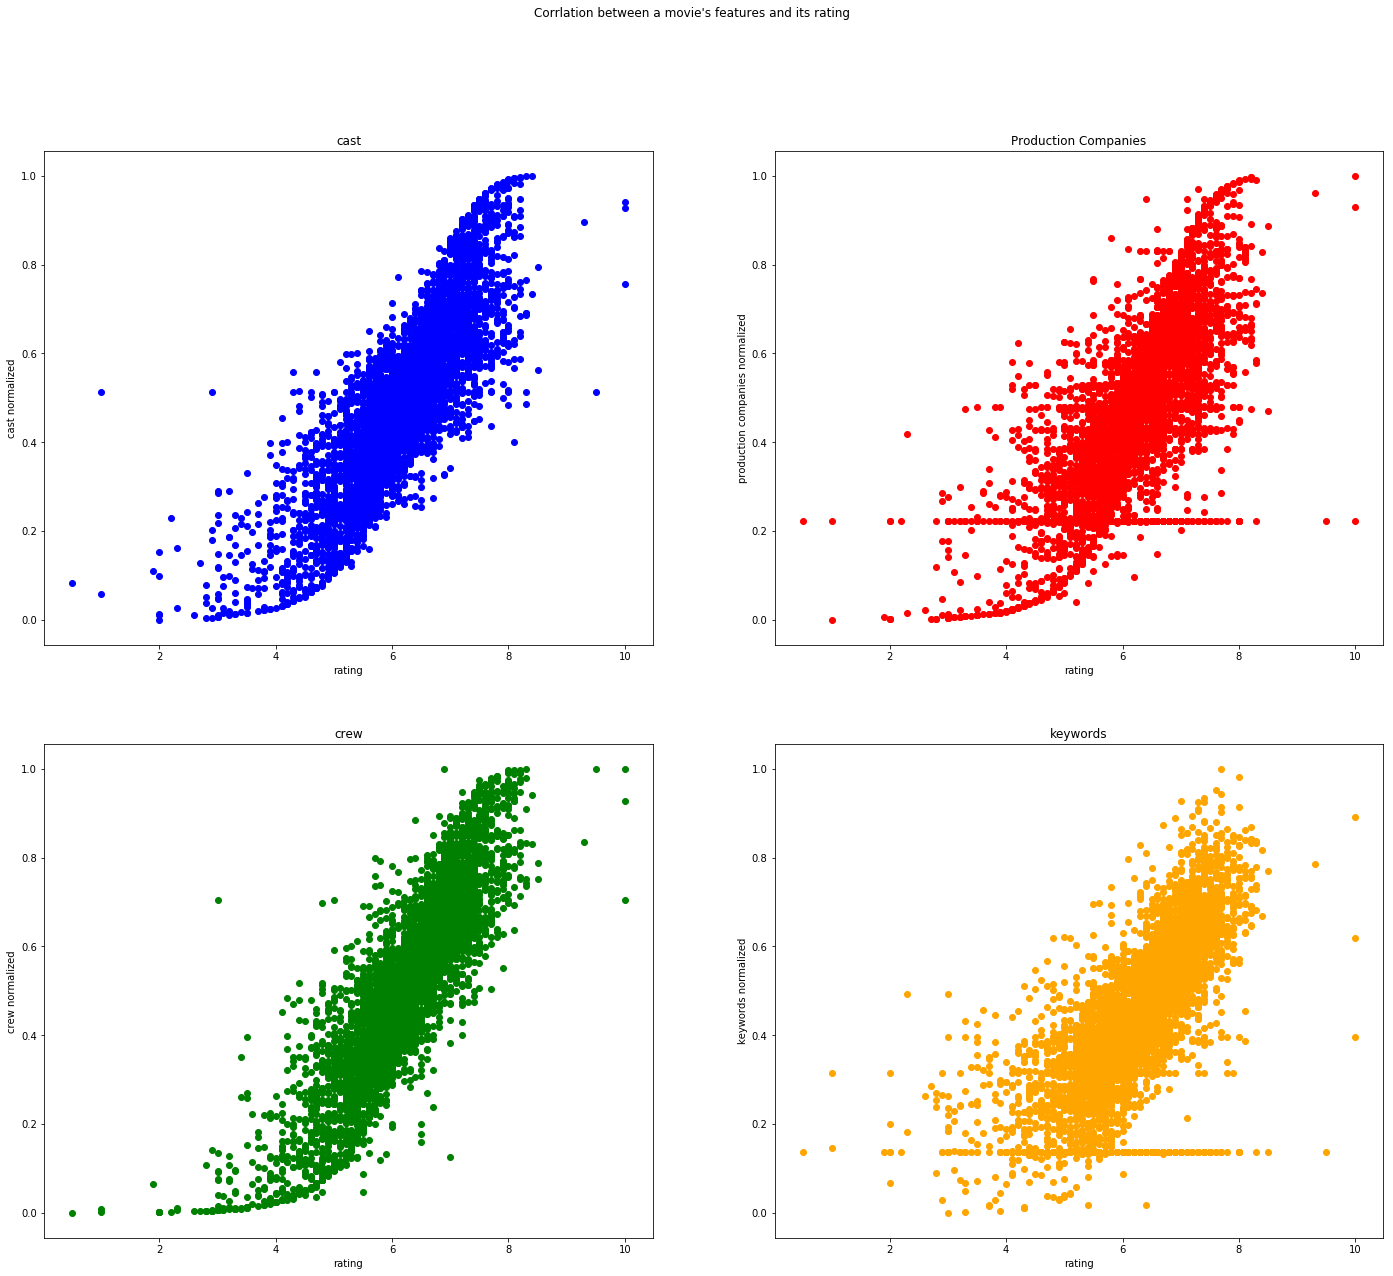

In [161]:
fig, ax = plt.subplots(2,2, figsize=(24,20))

ax[0,0].scatter(target_df['ratings'], feat_scaled['cast'], facecolor='blue')
ax[0,0].set_xlabel('rating')
ax[0,0].set_ylabel('cast normalized')
ax[0,0].set_title('cast')

ax[1,0].scatter(target_df['ratings'], feat_scaled['crew'], facecolor='green')
ax[1,0].set_xlabel('rating')
ax[1,0].set_ylabel('crew normalized')
ax[1,0].set_title('crew')

ax[0,1].scatter(target_df['ratings'], feat_scaled['production_companies'], facecolor='red')
ax[0,1].set_xlabel('rating')
ax[0,1].set_ylabel('production companies normalized')
ax[0,1].set_title('Production Companies')

ax[1,1].scatter(target_df['ratings'], feat_scaled['keywords'], facecolor='orange')
ax[1,1].set_xlabel('rating')
ax[1,1].set_ylabel('keywords normalized')
ax[1,1].set_title('keywords')

fig.suptitle("Corrlation between a movie's features and its rating")

As you can see, there's a clear correlation between the features and the ratings
The straight lines in figures for keywords and production companies represents the absence of keywords and production companies for certain movies

### Split Data into testing and training
Will be splitting trainting : testing : validation -> (0.7) : (0.15) : (0.15)

In [162]:
from sklearn.model_selection import train_test_split
def train_test_val_split(df_feat, df_target, train_frac):
    train_features, test_features, train_target, test_target = train_test_split(df_feat, df_target, test_size = train_frac) #splitting training from rest of the dataset
    return (train_features, train_target), (test_features, test_target)

In [163]:
(features_train, target_train), (features_test, target_test) = train_test_val_split(feat_scaled, target_df,0.7)

In [164]:
target_train.head()

,ratings
1758,7.4
3346,6.0
1980,5.0
1060,5.8
1347,5.8


## Creating the model

#### Import Scikit Learn's [Bayesian Ridge][bayes] Regressor

Bayesian ridge is one of many regression models offered by Scikit Learn. I'm choosing this model because it's ideal for dealing with data containing multiple outliers (movies with ratings inconsistent with its features)


[//]: # (These are reference links used in the body of this note and get stripped out when the markdown processor does its job. There is no need to format nicely because it shouldn't be seen. Thanks SO - http://stackoverflow.com/questions/4823468/store-comments-in-markdown-syntax)


   [bayes]: <https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge>

In [165]:
from sklearn.linear_model import BayesianRidge

#### Create and train model

In [166]:
reg = BayesianRidge()
reg.fit(features_train.values, target_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

#### Make predictions with features_test

In [167]:
target_pred = reg.predict(features_test.values)

## Evaluation
#### Plot predictions vs test ratings

Text(0.5, 1.0, 'Movie ratings vs Predicted ratings')

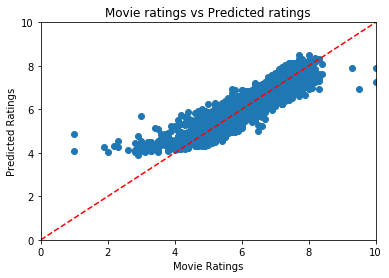

In [168]:
plt.axis([0,10,0,10])
plt.scatter(target_test, target_pred)

index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')             
plt.xlabel("Movie Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Movie ratings vs Predicted ratings")

#### Get R^2 score

An [r^2 score][r2] is ideal for regression models because it gauges how well the variance of movie ratings can be explained by the features used (cast, crew, production companies, and keywords)

[//]: # (These are reference links used in the body of this note and get stripped out when the markdown processor does its job. There is no need to format nicely because it shouldn't be seen. Thanks SO - http://stackoverflow.com/questions/4823468/store-comments-in-markdown-syntax)


   [r2]: <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html>


In [169]:
from sklearn.metrics import r2_score

score = r2_score(target_test, target_pred)

print("R^2 Score for predictions:", score)

R^2 Score for predictions: 0.7998191339103948


## Conclusion

Though 0.7997 shows that the variance of ratings in can be explained by movie features, Although its not very high.
    

# **Now making a recommendation engine**
Making recommendation based on plot


In [182]:
movie = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_movies.csv")
credit = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_credits.csv")
credit.columns = ['id','tittle','cast','crew']
movies = movie.merge(credit,on='id')

In [183]:
movies['overview'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object



Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. 

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
movies['overview'] = movies['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)



We see that over 20,808 different words were used to describe the 4732 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.


In [185]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)



We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.


In [186]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()



We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

    Get the index of the movie given its title.
    Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
    Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
    Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
    Return the titles corresponding to the indices of the top elements.



In [187]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

In [188]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object



While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.



Credits, Genres and Keywords Based Recommender

It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure


In [189]:
# Parse the stringified features into their corresponding python object

from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [190]:
#Now we will write function to extract information from each function
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [191]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [194]:
# Define new director, cast, genres and keywords features that are in a suitable form.
movies['director'] = movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [196]:
# Print the new features of the first 3 films
movies[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [197]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [198]:


# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)



We are now in a position to create our "metadata set", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [199]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies['soup'] = movies.apply(create_soup, axis=1)

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [200]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])

In [201]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [203]:
# Reset index of our main DataFrame and construct reverse mapping as before
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

In [204]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

This is giving better recommendation than previous systme.Lets try some more movies

In [205]:
get_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

In [208]:
get_recommendations('Before Sunrise')

381     The Nutcracker: The Untold Story
3064                    Run, Fatboy, Run
4088                       Before Sunset
1934                     Say It Isn't So
1680         Savva. Heart of the Warrior
4661                      The Big Parade
4640         Love and Other Catastrophes
2872                From Justin to Kelly
2233                          Little Boy
967                            Hereafter
Name: title, dtype: object

In [ ]:
get_recommendations('Pulp Fiction')